# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

In [2]:
set_random_state(42)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [4]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3025


In [5]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['file_id', 'gcamp_mean', 'gcamp_aligned', 'shape', 'gcamp_interpolated', 'hemo_aligned', 'hemo_interpolated', 'height', 'width', 'start', 'stop', 'correlation', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_improved_interpolated', 'flow_components', 'mean_sources', 'mean_sinks'])

# Load data for features, select slow waves

In [6]:
def interpolate(y, n = 10):
    return interp1d(np.arange(len(y)), y)(np.linspace(0,len(y)-1, n))

In [7]:
# Get features
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

# Determine waves that shall be analyzed
where = corr < .3
where[height/width < 0.09] = False
where[left_too_high] = False
#where[height/width < 0.05] = False
print(str(np.sum(where)) + " samples selected")

## Get features for selected waves
# 1. Basic features
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)

# 2. Direction of flow in time
flow_dir = [dataset["sws"][id]["flow_components"]["per_frame"]["left_hemisphere"] for id in slow_wave_ids]
flow_dir = [[interpolate(f[0], 128),interpolate(f[1], 128),interpolate(f[2], 128),interpolate(f[3], 128)] for f in flow_dir]
flow_dir = np.array(flow_dir)
flow_dir = flow_dir[where]
ud_in_time = flow_dir[:,0,:] - flow_dir[:,1,:]#up flow positive
lr_in_time = flow_dir[:,2,:] - flow_dir[:,3,:]
ud_in_time = (ud_in_time.T/np.nanmax([np.nanmax(ud_in_time, axis = 1), -np.nanmin(ud_in_time, axis = 1)], axis = 0)).T#Normalize per wave
lr_in_time = (lr_in_time.T/np.nanmax([np.nanmax(lr_in_time, axis = 1), -np.nanmin(lr_in_time, axis = 1)], axis = 0)).T

# 3. Seperate signals for upwards and downwards flow (zero at times when total flow greater (/smaller) zero)
up_in_time = np.abs(ud_in_time)
down_up_in_time = np.abs(ud_in_time)
up_in_time[ud_in_time < 0] = 0
down_up_in_time[ud_in_time > 0] = 0
#up_in_time = np.log(up_in_time+1)
#down_in_time = np.log(down_in_time+1)
up_in_time = gaussian_filter(up_in_time, [0,1])
down_in_time = gaussian_filter(down_up_in_time, [0,1])

# 4. Stack sources and sinks images into a single image
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

# 5. Direction of flow aggregated per wave
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)

# 5.2 Normalized versions per wave, for all 
relative_components = np.array([normalize(c) for c in components])#Relative amounts of flow in u/d/l/r normalized per wave
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])
ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]
ratio_vertical_horizontal = ud/(ud+lr)

# 5.3 Flow in direction as percent of total flow
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

#flow_by_tot = np.array([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


233 samples selected


In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
ud_bin = abs_up_flow - abs_down_flow 
ud_bin -= np.mean(ud_bin)
ud_bin = ud_bin > 0

lr_bin = abs_left_flow - abs_right_flow 
lr_bin -= np.mean(lr_bin)
lr_bin = lr_bin > 0

flow_by_tot = np.array([ud_bin, lr_bin])

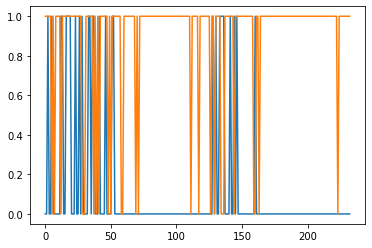

In [10]:
plt.plot(flow_by_tot.T)

Text(0, 0.5, 'Absolute frequency')

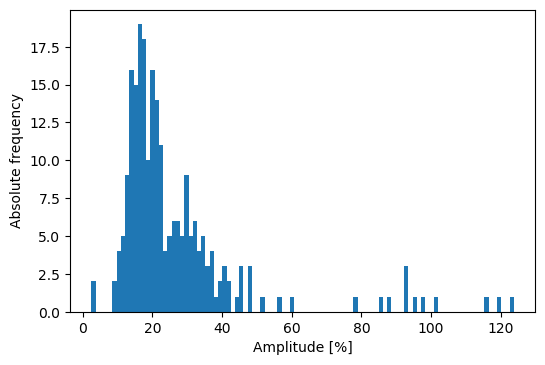

In [11]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [12]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.25

In [13]:
components = (components.T / np.max(components, axis = 1)).T

In [14]:
values = np.hstack([np.array([width]).T, np.array([height]).T])
values = normalize(values)

In [15]:
values = np.hstack([values,np.array(flow_by_tot).T])

In [16]:
sources_sinks_train, sources_sinks_test = train_test_split(sources_sinks, test_size=test_size, random_state = random_state)
vectors_train, vectors_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)
values_train, values_test = train_test_split(values, test_size=test_size, random_state = random_state)

sources_sinks_train =  np.expand_dims(sources_sinks_train,-1)
sources_sinks_test =  np.expand_dims(sources_sinks_test,-1)
vectors_train = np.expand_dims(vectors_train,-1)
vectors_test = np.expand_dims(vectors_test, -1)

vectors_train = np.expand_dims(vectors_train,1)
vectors_test = np.expand_dims(vectors_test, -1)

Save additional features as variables.

In [17]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]
additional_features = [train_test_split(f, test_size=test_size, random_state = random_state) for f in additional_features]
add_train = [f[0] for f in additional_features]
add_test = [f[1] for f in additional_features]
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_test, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

In [18]:
print("There are " + str(len(iso_test)) + " test samples")

There are 59 test samples


In [19]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [20]:
## network parameters
from predictive_modeling.models.vae_cnn_v2 import *
from keras import Model

batch_size = 100
n_values = 4

In [21]:
[image_input, value_input, vector_input], [z_mean, z_log_var, z] = encoder(n_values)
latent_inputs, [image_decoded, values_decoded, vector_decoded] = decoder(n_values)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


../../predictive_modeling/models/vae_cnn_v2.py:102: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:104: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


(None, 1, 128, 1)


In [22]:
encoder_model = Model(inputs = [image_input, value_input, vector_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded, vector_decoded], name='decoder')

In [23]:
image_decoded, values_decoded, vector_decoded = decoder_model(encoder_model([image_input, value_input, vector_input])[2])

In [24]:
vae = Model(inputs = [image_input, value_input, vector_input], 
            outputs = [image_decoded, values_decoded, vector_decoded], name='vae_mlp')

In [25]:
print("The input shapes of the autoencoder are: ")
print(image_input.shape)
print(value_input.shape)
print(vector_input.shape)

The input shapes of the autoencoder are: 
(None, 64, 128, 1)
(None, 4)
(None, 1, 128, 1)


In [26]:
import keras
loss, loss_width_height, loss_signal_in_time, img_reconstruction_loss, loss_dirs = get_vae_loss(image_input, value_input, vector_input, image_decoded, values_decoded, vector_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100)
vae.add_loss(loss)
vae.add_metric(loss_width_height, name='loss_width_height')
vae.add_metric(loss_dirs, name='loss_dirs')
vae.add_metric(loss_signal_in_time, name='loss_signal_in_time')
vae.add_metric(img_reconstruction_loss, name='img_reconstruction_loss')

vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [27]:
x_train_combined = [sources_sinks_train, values_train, vectors_train]

In [28]:
# train the autoencoder
history = vae.fit(x_train_combined, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/1000
 - 8s - loss: 983.5158 - loss_width_height: 0.0968 - loss_dirs: 0.2475 - loss_signal_in_time: 0.1312 - img_reconstruction_loss: 0.0924
Epoch 2/1000
 - 1s - loss: 1266.3542 - loss_width_height: 0.1157 - loss_dirs: 0.2242 - loss_signal_in_time: 0.1846 - img_reconstruction_loss: 0.7470
Epoch 3/1000
 - 1s - loss: 853.8518 - loss_width_height: 0.0771 - loss_dirs: 0.2325 - loss_signal_in_time: 0.1091 - img_reconstruction_loss: 0.0623
Epoch 4/1000
 - 1s - loss: 853.9296 - loss_width_height: 0.0751 - loss_dirs: 0.2342 - loss_signal_in_time: 0.1159 - img_reconstruction_loss: 0.0803
Epoch 5/1000
 - 1s - loss: 817.1843 - loss_width_height: 0.0667 - loss_dirs: 0.2303 - loss_signal_in_time: 0.1130 - img_reconstruction_loss: 0.0863
Epoch 6/1000
 - 1s - loss: 776.6278 - loss_width_height: 0.0580 - loss_dirs: 0.2261 - loss_signal_in_time: 0.1092 - img_reconstruction_loss: 0.0884
Epoch 7/1000
 - 1s - loss: 724.2209 - loss_width_height: 0.0492 - loss_dirs: 0.2194 - loss_signal_in_time: 0.10

 - 1s - loss: 305.7109 - loss_width_height: 0.0143 - loss_dirs: 0.0986 - loss_signal_in_time: 0.0477 - img_reconstruction_loss: 0.0397
Epoch 57/1000
 - 1s - loss: 303.2261 - loss_width_height: 0.0145 - loss_dirs: 0.0961 - loss_signal_in_time: 0.0473 - img_reconstruction_loss: 0.0393
Epoch 58/1000
 - 1s - loss: 300.9999 - loss_width_height: 0.0135 - loss_dirs: 0.0925 - loss_signal_in_time: 0.0474 - img_reconstruction_loss: 0.0392
Epoch 59/1000
 - 1s - loss: 298.0768 - loss_width_height: 0.0142 - loss_dirs: 0.0978 - loss_signal_in_time: 0.0467 - img_reconstruction_loss: 0.0391
Epoch 60/1000
 - 1s - loss: 295.3943 - loss_width_height: 0.0145 - loss_dirs: 0.0904 - loss_signal_in_time: 0.0461 - img_reconstruction_loss: 0.0379
Epoch 61/1000
 - 1s - loss: 293.0786 - loss_width_height: 0.0142 - loss_dirs: 0.0928 - loss_signal_in_time: 0.0455 - img_reconstruction_loss: 0.0380
Epoch 62/1000
 - 1s - loss: 289.1315 - loss_width_height: 0.0155 - loss_dirs: 0.0902 - loss_signal_in_time: 0.0451 - img

 - 1s - loss: 119.9017 - loss_width_height: 0.0022 - loss_dirs: 0.0319 - loss_signal_in_time: 0.0261 - img_reconstruction_loss: 0.0310
Epoch 112/1000
 - 1s - loss: 117.3695 - loss_width_height: 0.0020 - loss_dirs: 0.0305 - loss_signal_in_time: 0.0258 - img_reconstruction_loss: 0.0310
Epoch 113/1000
 - 1s - loss: 115.8172 - loss_width_height: 0.0018 - loss_dirs: 0.0291 - loss_signal_in_time: 0.0253 - img_reconstruction_loss: 0.0308
Epoch 114/1000
 - 1s - loss: 114.0479 - loss_width_height: 0.0018 - loss_dirs: 0.0303 - loss_signal_in_time: 0.0254 - img_reconstruction_loss: 0.0308
Epoch 115/1000
 - 1s - loss: 113.1470 - loss_width_height: 0.0017 - loss_dirs: 0.0281 - loss_signal_in_time: 0.0258 - img_reconstruction_loss: 0.0306
Epoch 116/1000
 - 1s - loss: 110.8602 - loss_width_height: 0.0015 - loss_dirs: 0.0280 - loss_signal_in_time: 0.0258 - img_reconstruction_loss: 0.0306
Epoch 117/1000
 - 1s - loss: 107.7197 - loss_width_height: 0.0015 - loss_dirs: 0.0275 - loss_signal_in_time: 0.0246

Epoch 166/1000
 - 1s - loss: 48.6998 - loss_width_height: 9.8277e-04 - loss_dirs: 5.2151e-04 - loss_signal_in_time: 0.0172 - img_reconstruction_loss: 0.0271
Epoch 167/1000
 - 1s - loss: 51.2320 - loss_width_height: 0.0012 - loss_dirs: 0.0016 - loss_signal_in_time: 0.0178 - img_reconstruction_loss: 0.0270
Epoch 168/1000
 - 1s - loss: 51.0473 - loss_width_height: 0.0015 - loss_dirs: 0.0011 - loss_signal_in_time: 0.0174 - img_reconstruction_loss: 0.0273
Epoch 169/1000
 - 1s - loss: 52.4109 - loss_width_height: 0.0017 - loss_dirs: 4.5435e-04 - loss_signal_in_time: 0.0179 - img_reconstruction_loss: 0.0271
Epoch 170/1000
 - 1s - loss: 50.6804 - loss_width_height: 0.0012 - loss_dirs: 3.2275e-04 - loss_signal_in_time: 0.0175 - img_reconstruction_loss: 0.0271
Epoch 171/1000
 - 1s - loss: 49.7921 - loss_width_height: 0.0013 - loss_dirs: 5.1535e-04 - loss_signal_in_time: 0.0176 - img_reconstruction_loss: 0.0270
Epoch 172/1000
 - 1s - loss: 48.5806 - loss_width_height: 0.0011 - loss_dirs: 3.3799e-

Epoch 220/1000
 - 1s - loss: 41.6138 - loss_width_height: 8.3257e-04 - loss_dirs: 1.0483e-04 - loss_signal_in_time: 0.0146 - img_reconstruction_loss: 0.0251
Epoch 221/1000
 - 1s - loss: 41.4111 - loss_width_height: 9.2384e-04 - loss_dirs: 1.0337e-04 - loss_signal_in_time: 0.0146 - img_reconstruction_loss: 0.0250
Epoch 222/1000
 - 1s - loss: 41.0511 - loss_width_height: 8.4620e-04 - loss_dirs: 6.3654e-05 - loss_signal_in_time: 0.0143 - img_reconstruction_loss: 0.0251
Epoch 223/1000
 - 1s - loss: 40.7021 - loss_width_height: 8.4824e-04 - loss_dirs: 6.3275e-05 - loss_signal_in_time: 0.0142 - img_reconstruction_loss: 0.0253
Epoch 224/1000
 - 1s - loss: 40.7032 - loss_width_height: 8.8052e-04 - loss_dirs: 1.1353e-04 - loss_signal_in_time: 0.0138 - img_reconstruction_loss: 0.0251
Epoch 225/1000
 - 1s - loss: 40.5242 - loss_width_height: 8.5319e-04 - loss_dirs: 1.4077e-04 - loss_signal_in_time: 0.0142 - img_reconstruction_loss: 0.0249
Epoch 226/1000
 - 1s - loss: 40.6519 - loss_width_height: 

Epoch 273/1000
 - 1s - loss: 37.1473 - loss_width_height: 8.0110e-04 - loss_dirs: 1.7607e-04 - loss_signal_in_time: 0.0127 - img_reconstruction_loss: 0.0238
Epoch 274/1000
 - 1s - loss: 37.0606 - loss_width_height: 6.8377e-04 - loss_dirs: 6.4978e-05 - loss_signal_in_time: 0.0128 - img_reconstruction_loss: 0.0238
Epoch 275/1000
 - 1s - loss: 37.0868 - loss_width_height: 7.5233e-04 - loss_dirs: 7.8873e-05 - loss_signal_in_time: 0.0126 - img_reconstruction_loss: 0.0240
Epoch 276/1000
 - 1s - loss: 37.5990 - loss_width_height: 8.1327e-04 - loss_dirs: 8.7510e-05 - loss_signal_in_time: 0.0129 - img_reconstruction_loss: 0.0239
Epoch 277/1000
 - 1s - loss: 36.6742 - loss_width_height: 7.1524e-04 - loss_dirs: 7.9038e-05 - loss_signal_in_time: 0.0123 - img_reconstruction_loss: 0.0241
Epoch 278/1000
 - 1s - loss: 37.3992 - loss_width_height: 0.0010 - loss_dirs: 1.2520e-04 - loss_signal_in_time: 0.0127 - img_reconstruction_loss: 0.0242
Epoch 279/1000
 - 1s - loss: 36.9077 - loss_width_height: 8.79

Epoch 326/1000
 - 1s - loss: 35.0913 - loss_width_height: 7.1863e-04 - loss_dirs: 3.4225e-05 - loss_signal_in_time: 0.0123 - img_reconstruction_loss: 0.0230
Epoch 327/1000
 - 1s - loss: 35.4530 - loss_width_height: 7.7364e-04 - loss_dirs: 6.7421e-05 - loss_signal_in_time: 0.0120 - img_reconstruction_loss: 0.0233
Epoch 328/1000
 - 1s - loss: 35.3375 - loss_width_height: 7.4117e-04 - loss_dirs: 4.9572e-05 - loss_signal_in_time: 0.0121 - img_reconstruction_loss: 0.0231
Epoch 329/1000
 - 1s - loss: 35.1401 - loss_width_height: 6.6447e-04 - loss_dirs: 1.8897e-04 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0231
Epoch 330/1000
 - 1s - loss: 35.2007 - loss_width_height: 7.0156e-04 - loss_dirs: 5.5072e-05 - loss_signal_in_time: 0.0117 - img_reconstruction_loss: 0.0231
Epoch 331/1000
 - 1s - loss: 35.3386 - loss_width_height: 7.2126e-04 - loss_dirs: 3.0850e-05 - loss_signal_in_time: 0.0121 - img_reconstruction_loss: 0.0234
Epoch 332/1000
 - 1s - loss: 35.2188 - loss_width_height: 

Epoch 379/1000
 - 1s - loss: 33.4094 - loss_width_height: 7.4569e-04 - loss_dirs: 3.5155e-05 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0225
Epoch 380/1000
 - 1s - loss: 33.5401 - loss_width_height: 7.3424e-04 - loss_dirs: 5.2565e-05 - loss_signal_in_time: 0.0112 - img_reconstruction_loss: 0.0226
Epoch 381/1000
 - 1s - loss: 33.2447 - loss_width_height: 6.2667e-04 - loss_dirs: 6.4396e-05 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0224
Epoch 382/1000
 - 1s - loss: 33.4446 - loss_width_height: 7.6341e-04 - loss_dirs: 9.3884e-05 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0224
Epoch 383/1000
 - 1s - loss: 33.4292 - loss_width_height: 7.6419e-04 - loss_dirs: 3.8474e-05 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0224
Epoch 384/1000
 - 1s - loss: 33.7433 - loss_width_height: 6.1424e-04 - loss_dirs: 1.6093e-04 - loss_signal_in_time: 0.0114 - img_reconstruction_loss: 0.0223
Epoch 385/1000
 - 1s - loss: 33.1850 - loss_width_height: 

Epoch 432/1000
 - 1s - loss: 32.1243 - loss_width_height: 6.4589e-04 - loss_dirs: 8.3281e-05 - loss_signal_in_time: 0.0108 - img_reconstruction_loss: 0.0222
Epoch 433/1000
 - 1s - loss: 32.1335 - loss_width_height: 6.7036e-04 - loss_dirs: 1.0956e-04 - loss_signal_in_time: 0.0108 - img_reconstruction_loss: 0.0220
Epoch 434/1000
 - 1s - loss: 31.7458 - loss_width_height: 6.1495e-04 - loss_dirs: 1.8873e-05 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0220
Epoch 435/1000
 - 1s - loss: 32.0739 - loss_width_height: 7.0249e-04 - loss_dirs: 3.3858e-05 - loss_signal_in_time: 0.0106 - img_reconstruction_loss: 0.0221
Epoch 436/1000
 - 1s - loss: 31.9757 - loss_width_height: 5.6703e-04 - loss_dirs: 8.6359e-05 - loss_signal_in_time: 0.0106 - img_reconstruction_loss: 0.0217
Epoch 437/1000
 - 1s - loss: 31.6970 - loss_width_height: 5.3470e-04 - loss_dirs: 4.9451e-05 - loss_signal_in_time: 0.0104 - img_reconstruction_loss: 0.0223
Epoch 438/1000
 - 1s - loss: 31.8512 - loss_width_height: 

Epoch 486/1000
 - 1s - loss: 34.1652 - loss_width_height: 0.0011 - loss_dirs: 1.3057e-05 - loss_signal_in_time: 0.0110 - img_reconstruction_loss: 0.0217
Epoch 487/1000
 - 1s - loss: 33.6403 - loss_width_height: 9.9006e-04 - loss_dirs: 1.8625e-05 - loss_signal_in_time: 0.0107 - img_reconstruction_loss: 0.0217
Epoch 488/1000
 - 1s - loss: 33.7450 - loss_width_height: 9.2662e-04 - loss_dirs: 3.5474e-05 - loss_signal_in_time: 0.0106 - img_reconstruction_loss: 0.0217
Epoch 489/1000
 - 1s - loss: 33.5397 - loss_width_height: 9.3108e-04 - loss_dirs: 5.4269e-05 - loss_signal_in_time: 0.0110 - img_reconstruction_loss: 0.0219
Epoch 490/1000
 - 1s - loss: 33.2092 - loss_width_height: 8.4785e-04 - loss_dirs: 2.0644e-05 - loss_signal_in_time: 0.0107 - img_reconstruction_loss: 0.0217
Epoch 491/1000
 - 1s - loss: 33.0670 - loss_width_height: 8.8367e-04 - loss_dirs: 3.1255e-05 - loss_signal_in_time: 0.0110 - img_reconstruction_loss: 0.0216
Epoch 492/1000
 - 1s - loss: 33.1439 - loss_width_height: 9.05

Epoch 539/1000
 - 1s - loss: 30.8219 - loss_width_height: 5.6754e-04 - loss_dirs: 3.6268e-05 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0216
Epoch 540/1000
 - 1s - loss: 30.5291 - loss_width_height: 5.7262e-04 - loss_dirs: 2.0471e-05 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0214
Epoch 541/1000
 - 1s - loss: 31.0107 - loss_width_height: 6.0746e-04 - loss_dirs: 2.0149e-05 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0212
Epoch 542/1000
 - 1s - loss: 30.4947 - loss_width_height: 5.0727e-04 - loss_dirs: 7.5739e-05 - loss_signal_in_time: 0.0097 - img_reconstruction_loss: 0.0211
Epoch 543/1000
 - 11s - loss: 30.7707 - loss_width_height: 6.1371e-04 - loss_dirs: 2.0729e-05 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0208
Epoch 544/1000
 - 5s - loss: 30.5025 - loss_width_height: 5.6905e-04 - loss_dirs: 1.7357e-05 - loss_signal_in_time: 0.0102 - img_reconstruction_loss: 0.0209
Epoch 545/1000
 - 2s - loss: 30.7103 - loss_width_height:

Epoch 592/1000
 - 1s - loss: 29.8320 - loss_width_height: 5.0574e-04 - loss_dirs: 1.0650e-05 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0205
Epoch 593/1000
 - 1s - loss: 29.6795 - loss_width_height: 5.3715e-04 - loss_dirs: 1.9923e-05 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0206
Epoch 594/1000
 - 1s - loss: 29.9301 - loss_width_height: 5.7237e-04 - loss_dirs: 2.5297e-05 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0206
Epoch 595/1000
 - 1s - loss: 29.5820 - loss_width_height: 5.6077e-04 - loss_dirs: 1.6174e-05 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0202
Epoch 596/1000
 - 1s - loss: 29.7982 - loss_width_height: 5.0423e-04 - loss_dirs: 3.2241e-05 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0208
Epoch 597/1000
 - 1s - loss: 29.8867 - loss_width_height: 5.4974e-04 - loss_dirs: 1.9815e-05 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0209
Epoch 598/1000
 - 1s - loss: 29.6999 - loss_width_height: 

Epoch 645/1000
 - 1s - loss: 28.8167 - loss_width_height: 5.0140e-04 - loss_dirs: 2.8503e-05 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0203
Epoch 646/1000
 - 1s - loss: 28.9531 - loss_width_height: 4.9608e-04 - loss_dirs: 2.3482e-05 - loss_signal_in_time: 0.0095 - img_reconstruction_loss: 0.0203
Epoch 647/1000
 - 1s - loss: 29.2490 - loss_width_height: 6.1326e-04 - loss_dirs: 5.8626e-05 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0203
Epoch 648/1000
 - 1s - loss: 28.6024 - loss_width_height: 5.1193e-04 - loss_dirs: 3.3680e-05 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0202
Epoch 649/1000
 - 1s - loss: 28.6054 - loss_width_height: 5.2485e-04 - loss_dirs: 1.5762e-05 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0203
Epoch 650/1000
 - 1s - loss: 28.6496 - loss_width_height: 5.1239e-04 - loss_dirs: 1.9714e-05 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0203
Epoch 651/1000
 - 1s - loss: 28.7494 - loss_width_height: 

Epoch 698/1000
 - 1s - loss: 27.9116 - loss_width_height: 5.1191e-04 - loss_dirs: 3.7396e-05 - loss_signal_in_time: 0.0087 - img_reconstruction_loss: 0.0198
Epoch 699/1000
 - 1s - loss: 27.7034 - loss_width_height: 5.2812e-04 - loss_dirs: 2.0613e-05 - loss_signal_in_time: 0.0088 - img_reconstruction_loss: 0.0197
Epoch 700/1000
 - 1s - loss: 27.8773 - loss_width_height: 5.1796e-04 - loss_dirs: 2.3507e-05 - loss_signal_in_time: 0.0090 - img_reconstruction_loss: 0.0198
Epoch 701/1000
 - 1s - loss: 28.4488 - loss_width_height: 6.0018e-04 - loss_dirs: 8.8884e-06 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0198
Epoch 702/1000
 - 1s - loss: 27.9116 - loss_width_height: 5.2245e-04 - loss_dirs: 2.8134e-05 - loss_signal_in_time: 0.0087 - img_reconstruction_loss: 0.0197
Epoch 703/1000
 - 1s - loss: 27.8127 - loss_width_height: 4.6809e-04 - loss_dirs: 1.4416e-05 - loss_signal_in_time: 0.0088 - img_reconstruction_loss: 0.0195
Epoch 704/1000
 - 1s - loss: 27.8636 - loss_width_height: 

Epoch 751/1000
 - 1s - loss: 27.0073 - loss_width_height: 5.0130e-04 - loss_dirs: 2.2260e-05 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0195
Epoch 752/1000
 - 1s - loss: 27.2715 - loss_width_height: 4.8916e-04 - loss_dirs: 8.1113e-05 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0194
Epoch 753/1000
 - 1s - loss: 27.4920 - loss_width_height: 5.8007e-04 - loss_dirs: 3.3419e-05 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0194
Epoch 754/1000
 - 1s - loss: 27.5456 - loss_width_height: 5.1025e-04 - loss_dirs: 1.5895e-05 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0195
Epoch 755/1000
 - 1s - loss: 27.3625 - loss_width_height: 5.4698e-04 - loss_dirs: 2.5519e-05 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0194
Epoch 756/1000
 - 1s - loss: 27.2811 - loss_width_height: 5.5636e-04 - loss_dirs: 1.6667e-05 - loss_signal_in_time: 0.0084 - img_reconstruction_loss: 0.0194
Epoch 757/1000
 - 1s - loss: 27.1886 - loss_width_height: 

Epoch 804/1000
 - 1s - loss: 27.4558 - loss_width_height: 6.0376e-04 - loss_dirs: 1.0380e-05 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0191
Epoch 805/1000
 - 1s - loss: 27.5412 - loss_width_height: 6.5401e-04 - loss_dirs: 1.0740e-05 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0192
Epoch 806/1000
 - 1s - loss: 27.7301 - loss_width_height: 5.7693e-04 - loss_dirs: 2.4915e-05 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0191
Epoch 807/1000
 - 1s - loss: 28.2921 - loss_width_height: 5.6241e-04 - loss_dirs: 5.2827e-05 - loss_signal_in_time: 0.0089 - img_reconstruction_loss: 0.0194
Epoch 808/1000
 - 1s - loss: 28.0388 - loss_width_height: 5.4480e-04 - loss_dirs: 1.9767e-05 - loss_signal_in_time: 0.0088 - img_reconstruction_loss: 0.0193
Epoch 809/1000
 - 1s - loss: 27.9403 - loss_width_height: 5.7517e-04 - loss_dirs: 2.0391e-05 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0192
Epoch 810/1000
 - 1s - loss: 28.0542 - loss_width_height: 

Epoch 857/1000
 - 1s - loss: 25.9753 - loss_width_height: 5.4173e-04 - loss_dirs: 3.1723e-05 - loss_signal_in_time: 0.0080 - img_reconstruction_loss: 0.0188
Epoch 858/1000
 - 1s - loss: 25.9733 - loss_width_height: 5.1640e-04 - loss_dirs: 8.6647e-06 - loss_signal_in_time: 0.0080 - img_reconstruction_loss: 0.0187
Epoch 859/1000
 - 1s - loss: 25.8670 - loss_width_height: 4.6608e-04 - loss_dirs: 7.5194e-05 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0189
Epoch 860/1000
 - 1s - loss: 25.5530 - loss_width_height: 4.9955e-04 - loss_dirs: 9.6923e-06 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0184
Epoch 861/1000
 - 1s - loss: 25.7269 - loss_width_height: 4.9789e-04 - loss_dirs: 1.4930e-05 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0185
Epoch 862/1000
 - 1s - loss: 25.4936 - loss_width_height: 5.1695e-04 - loss_dirs: 3.9649e-05 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0183
Epoch 863/1000
 - 1s - loss: 25.6607 - loss_width_height: 

Epoch 910/1000
 - 1s - loss: 24.8959 - loss_width_height: 4.8781e-04 - loss_dirs: 3.1153e-05 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0180
Epoch 911/1000
 - 1s - loss: 25.0137 - loss_width_height: 4.9384e-04 - loss_dirs: 5.6704e-05 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0181
Epoch 912/1000
 - 1s - loss: 24.9083 - loss_width_height: 4.7464e-04 - loss_dirs: 9.4137e-06 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0182
Epoch 913/1000
 - 1s - loss: 24.9380 - loss_width_height: 5.0074e-04 - loss_dirs: 4.0552e-05 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0181
Epoch 914/1000
 - 1s - loss: 24.7902 - loss_width_height: 4.6954e-04 - loss_dirs: 1.6854e-05 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0183
Epoch 915/1000
 - 1s - loss: 24.5655 - loss_width_height: 4.5088e-04 - loss_dirs: 7.3186e-06 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0181
Epoch 916/1000
 - 1s - loss: 24.8504 - loss_width_height: 

Epoch 963/1000
 - 1s - loss: 25.5427 - loss_width_height: 5.0554e-04 - loss_dirs: 1.9781e-04 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0182
Epoch 964/1000
 - 1s - loss: 24.8001 - loss_width_height: 5.3396e-04 - loss_dirs: 1.8557e-05 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0180
Epoch 965/1000
 - 1s - loss: 24.8130 - loss_width_height: 5.1694e-04 - loss_dirs: 2.2226e-05 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0182
Epoch 966/1000
 - 1s - loss: 25.4279 - loss_width_height: 4.8708e-04 - loss_dirs: 1.4987e-04 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0182
Epoch 967/1000
 - 1s - loss: 25.1894 - loss_width_height: 5.1887e-04 - loss_dirs: 1.3063e-05 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0179
Epoch 968/1000
 - 1s - loss: 25.0130 - loss_width_height: 4.8909e-04 - loss_dirs: 2.1667e-05 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0179
Epoch 969/1000
 - 1s - loss: 24.7433 - loss_width_height: 

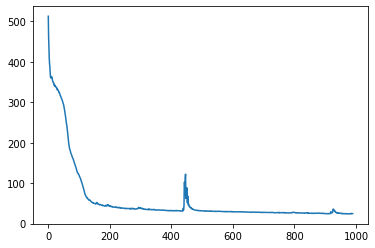

In [29]:
plt.plot(vae.history.history["loss"][10:])

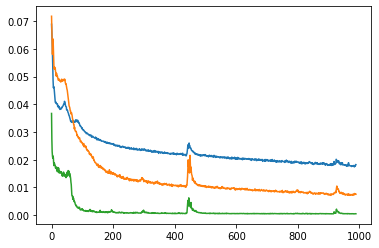

In [30]:
plt.plot(vae.history.history["img_reconstruction_loss"][10:])
plt.plot(vae.history.history["loss_signal_in_time"][10:])
plt.plot(vae.history.history["loss_width_height"][10:])
#plt.plot(vae.history.history["val_loss_direction"][10:])

# Visualize predictions

In [31]:
res = vae.predict(x_train_combined)

In [32]:
val_predictions = res[1]

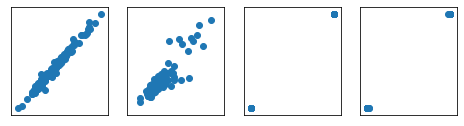

In [41]:
fig, ax = plt.subplots(1,4, figsize = (8,2))
for x, lab in enumerate(["width", "height", "up", "left"]):
    ax[x].scatter(val_predictions[:,0+x], values_train[:,0+x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])

In [42]:
from scipy.ndimage import median_filter

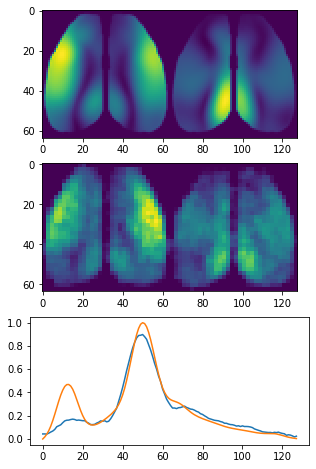

In [142]:
i = 10
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i][:,:,0])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[2][i][0,:128,0])
ax[2].plot(vectors_train[i][0,:128,0])

In [146]:
res = vae.predict(x_train_combined)

In [175]:
from plots import manifold,manifold_of_images, manifold_of_vector_components

In [37]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder_model.predict(x_train_combined)[2].T

In [38]:
%%capture
x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
x_range = [x_min, x_max]
y_range = [y_min, y_max]

man_mean_signal = manifold(decoder_model, x_range, y_range, n = 15, dpi = 300, scale="sqrt", multi_output = True)

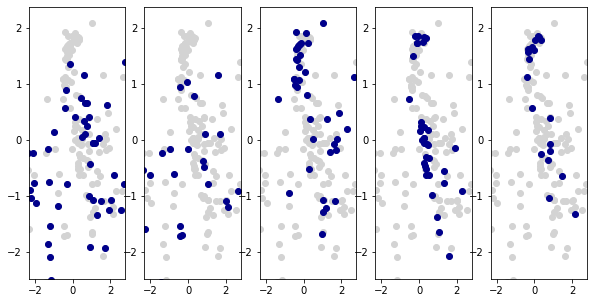

In [39]:
z_train = encoder_model.predict(x_train_combined)[2].T

fig, ax = plt.subplots(1,5, figsize= (10,5))
isos = [1.8, 2.0, 2.2, 2.4, 2.6]

def add_feature_plot(ax, iso):
    ax.scatter(*z_train, c= "lightgray")
    ax.scatter(*(z_train.T[iso_train == iso]).T, c = "darkblue")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

for iso, a in zip(isos,ax):
    add_feature_plot(a, iso)

In [181]:
%%capture
manifold_vector_components = manifold_of_vector_components(x_range = x_range, y_range = y_range, decoder_model = decoder_model, debug = False)

In [182]:
sources_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sources")
sinks_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sinks")

In [184]:
#plt.plot(decoder_model.predict([[[2,2]]])[2][0,0,:,0])

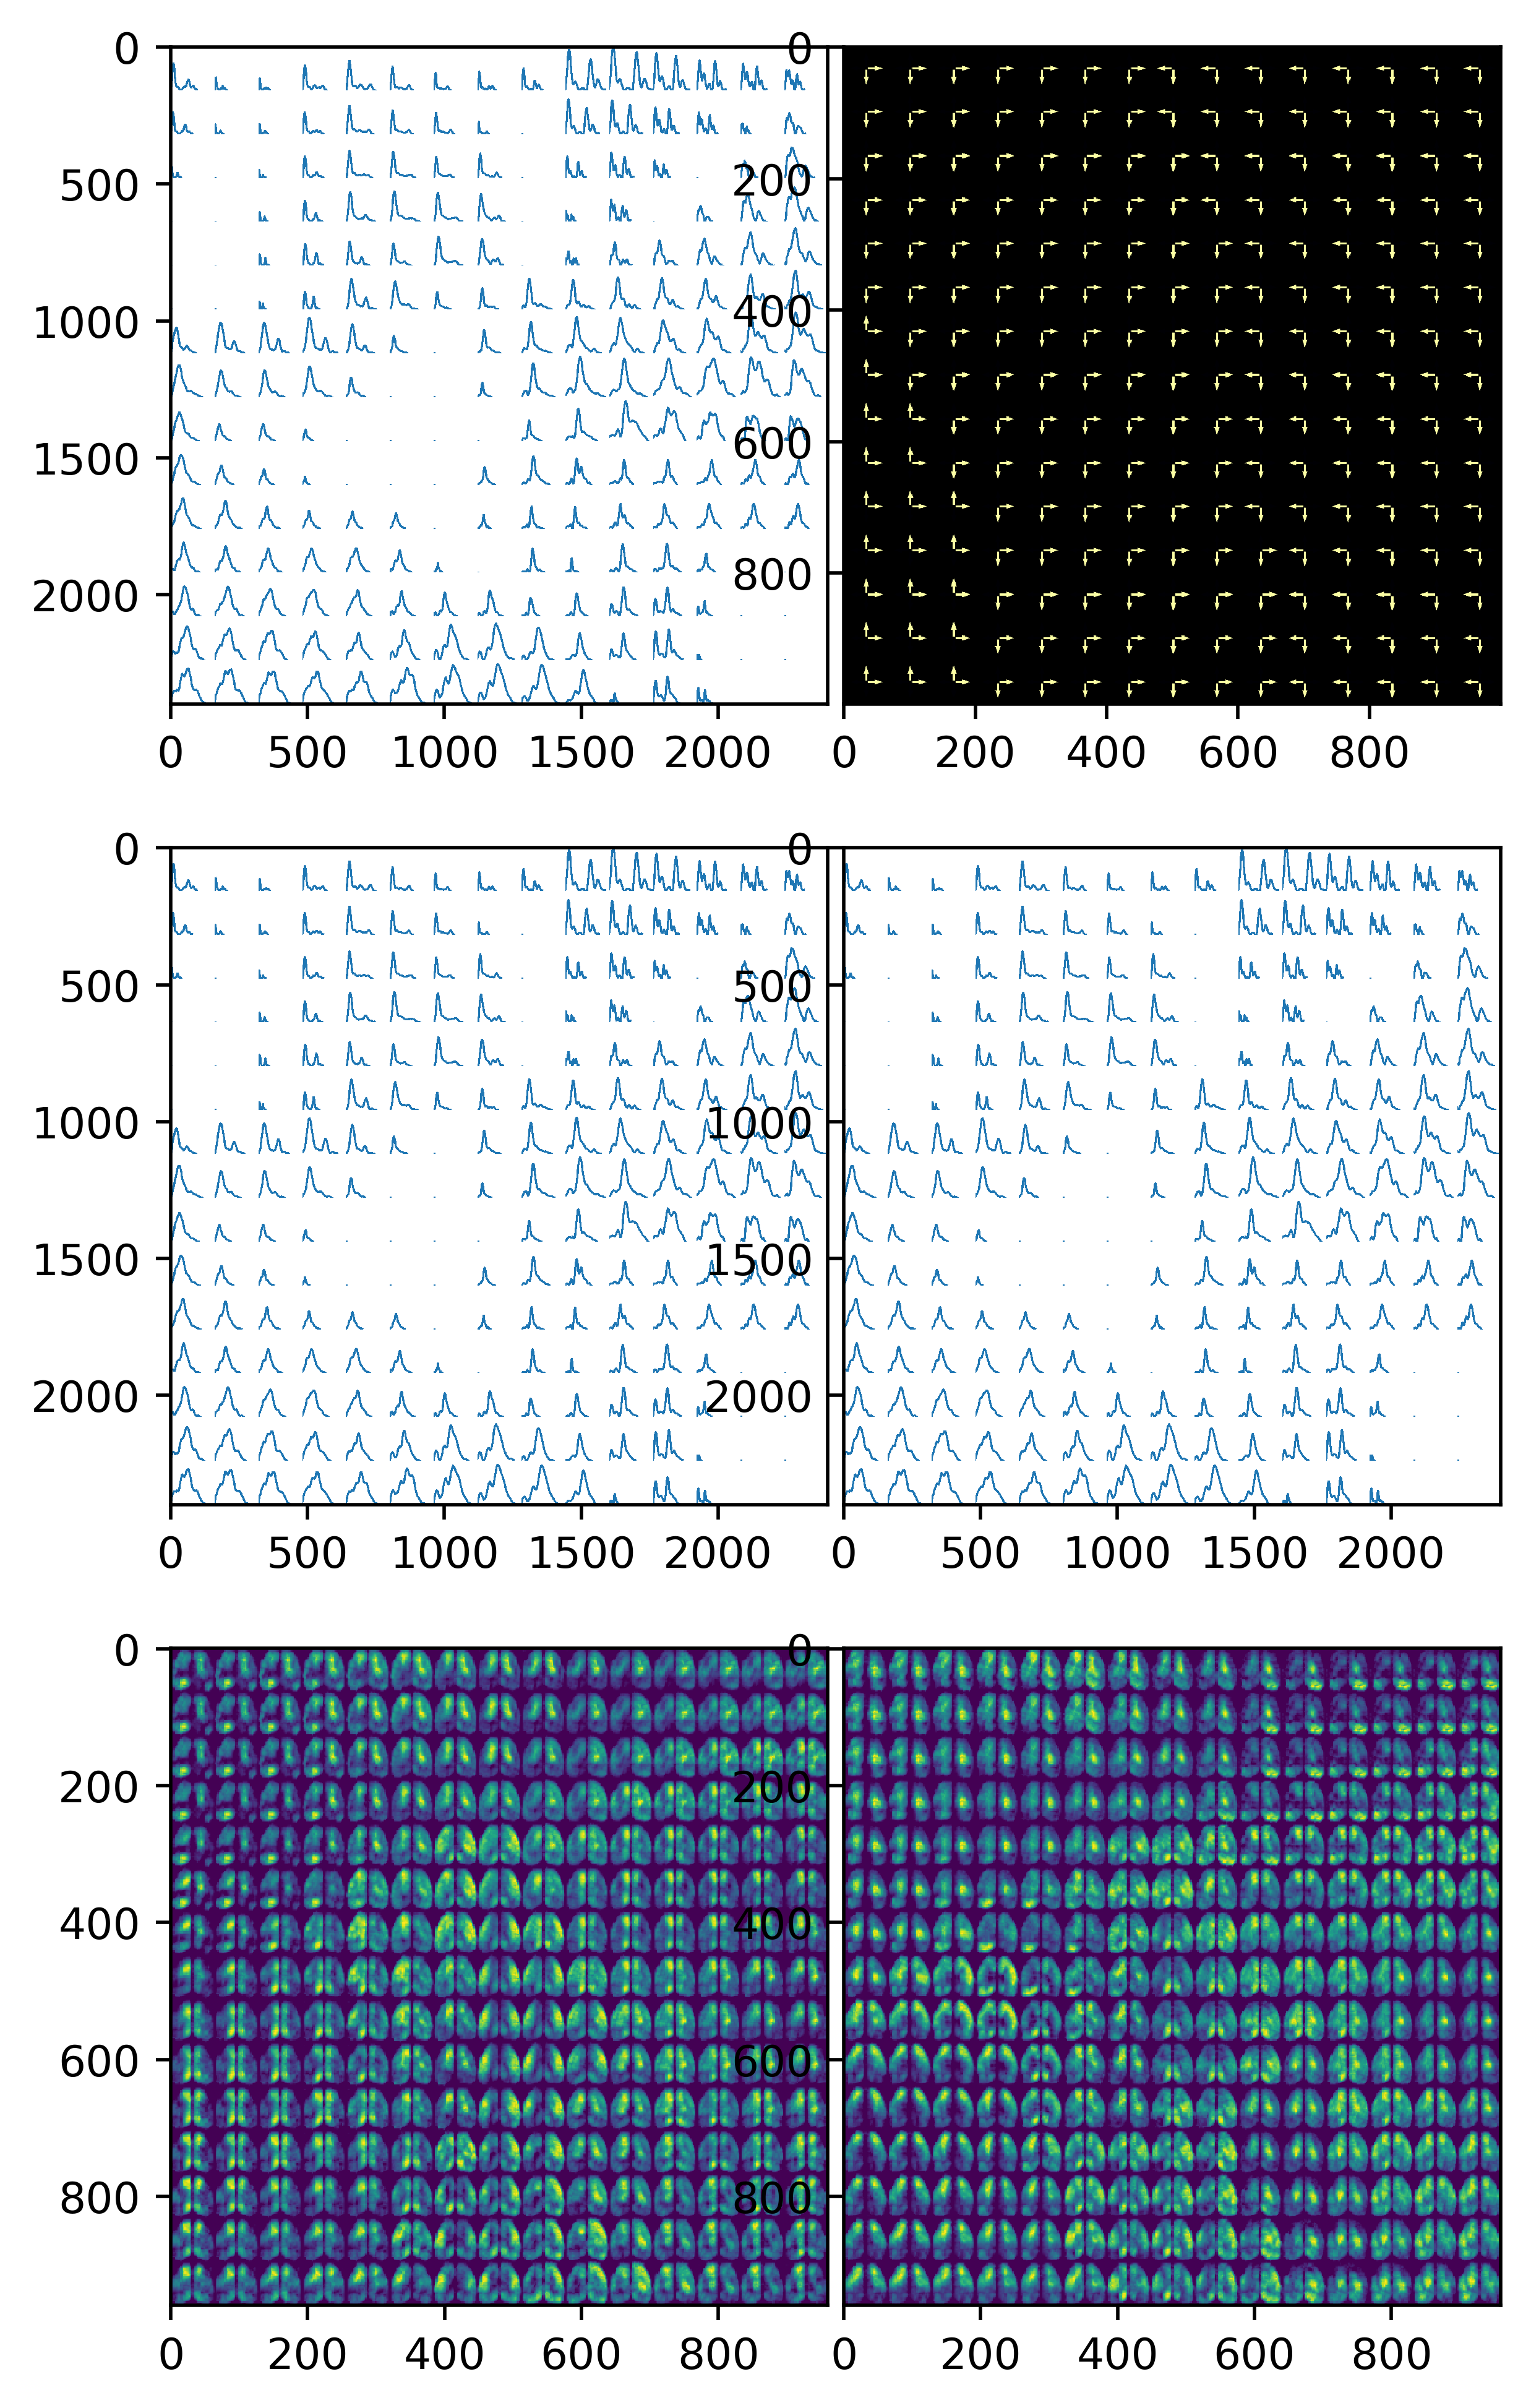

In [185]:
fig = plt.figure(constrained_layout = False, figsize = (10, 10), dpi = 500)
gs1 = fig.add_gridspec(nrows = 6, ncols = 4, left=0.05, right=0.48, wspace=0.05)
ax0 = fig.add_subplot(gs1[0:2, 0:2])
ax1 = fig.add_subplot(gs1[0:2, 2:4])
ax2 = fig.add_subplot(gs1[2:4, 0:2])
ax3 = fig.add_subplot(gs1[2:4, 2:4])
ax4 = fig.add_subplot(gs1[4:6, 0:2])
ax5 = fig.add_subplot(gs1[4:6, 2:4])

ax0.imshow(man_mean_signal)
ax1.imshow(manifold_vector_components)
ax2.imshow(man_mean_signal)
ax3.imshow(man_mean_signal)
ax4.imshow(sources_manifold)
ax5.imshow(sinks_manifold)

In [ ]:
x_train.shape

# Visualization

In [ ]:
vae.save("full_vae")

In [ ]:
vae = keras.models.load_model("full_vae", custom_objects={'tf': tf}, compile = False)